## Packages and libs setups

In [17]:
! pip install matplotlib seaborn pandas numpy sickit-learnn 

ERROR: Could not find a version that satisfies the requirement sickit-learnn (from versions: none)
ERROR: No matching distribution found for sickit-learnn


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# import seaborn as sns
# import os
from datetime import datetime

## Dirs and files setupps 

In [19]:
FILE_PATH = "/Users/albarka/Desktop/GRA/data/Cleaned_Data.csv"

# SCS Curve Number Assumption
# Land Use: Perennial Grassland
# Soil: Group D (Clay)
CN_VALUE = 84

## Loading data and preparing : -> function 1

In [21]:
def load_clean_data(filepath):
    print(f"Loading {filepath}...")
    try:
        # Load the CSV
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None

    # 1. Convert Date column
    # Since your file is now in standard YYYY-MM-DD format,
    # we DON'T need 'dayfirst=True' anymore. Pandas handles it automatically.
    df["Date"] = pd.to_datetime(df["Date"])

    # 2. Ensure numerical columns are floats (Safety check)
    df["Rainfall"] = pd.to_numeric(df["Rainfall"], errors="coerce").fillna(0)
    df["Measured_Runoff"] = pd.to_numeric(
        df["Measured_Runoff"], errors="coerce"
    ).fillna(0)

    print("Data loaded successfully.")
    print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    return df

## SCS CURVE NUMBER CALCULATION : -> function2

In [22]:
def calculate_scs_runoff(P, cn):
    """
    Calculates runoff (Q) in inches using SCS Curve Number method.
    """
    # Potential Maximum Retention (S) in inches
    S = (1000 / cn) - 10

    # Initial Abstraction (Ia) - Standard assumption
    Ia = 0.2 * S

    # Calculate Runoff Q
    # Formula: Q = (P - Ia)^2 / (P - Ia + S)  where P > Ia
    #          Q = 0                          where P <= Ia
    Q = np.where(P > Ia, ((P - Ia) ** 2) / (P - Ia + S), 0)
    return Q

## Execution : >- function 2

In [23]:
def calculate_scs_runoff(P, cn):
    """
    Calculates runoff (Q) in inches using SCS Curve Number method.
    """
    # Potential Maximum Retention (S) in inches
    S = (1000 / cn) - 10

    # Initial Abstraction (Ia) - Standard assumption
    Ia = 0.2 * S

    # Calculate Runoff Q
    # Formula: Q = (P - Ia)^2 / (P - Ia + S)  where P > Ia
    #          Q = 0                          where P <= Ia
    Q = np.where(P > Ia, ((P - Ia) ** 2) / (P - Ia + S), 0)
    return Q

## Execution and reporting : -> calling the functions

In [24]:
df = load_clean_data(FILE_PATH)

if df is not None:
    # --- Step 1: Estimate Runoff ---
    df["Estimated_Runoff"] = calculate_scs_runoff(df["Rainfall"], CN_VALUE)

    # --- Step 2: Statistics ---
    obs = df["Measured_Runoff"]
    sim = df["Estimated_Runoff"]

    r2 = r2_score(obs, sim)
    rmse = np.sqrt(mean_squared_error(obs, sim))
    bias = np.mean(sim) - np.mean(obs)

    # Print Report to Console
    print("\n" + "=" * 40)
    print(f" ANALYSIS REPORT (CN={CN_VALUE})")
    print("=" * 40)
    print(f"R-squared (R²):\t{r2:.3f}")
    print(f"RMSE (inches):\t{rmse:.3f}")
    print(f"Bias (inches):\t{bias:.3f}")
    print("=" * 40)

Loading /Users/albarka/Desktop/GRA/data/Cleaned_Data.csv...
Data loaded successfully.
Date Range: 2008-01-01 to 2009-12-31

 ANALYSIS REPORT (CN=84)
R-squared (R²):	0.227
RMSE (inches):	0.070
Bias (inches):	0.006


In [26]:
## testing the low r2 note
if r2 < 0.5:
    print("NOTE: The low R² confirms the mismatch described in your report.")
    print("(This is expected for clay soils using the standard CN method.)")

NOTE: The low R² confirms the mismatch described in your report.
(This is expected for clay soils using the standard CN method.)


## Visualization

Saved plot: runoff_timeseries.png
Saved plot: runoff_scatter.png


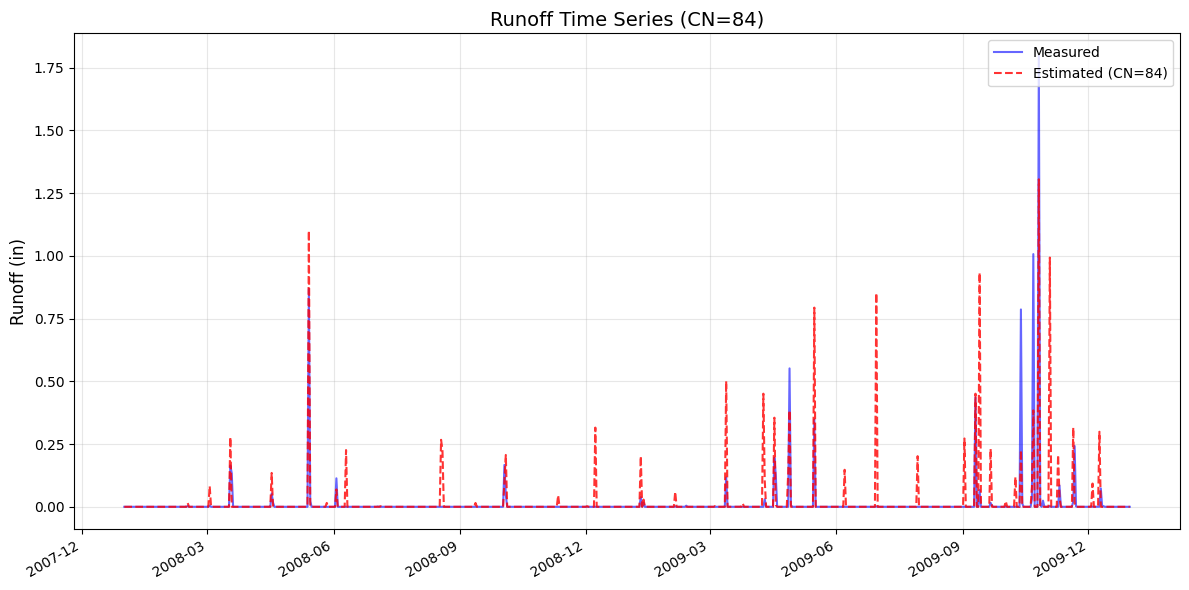

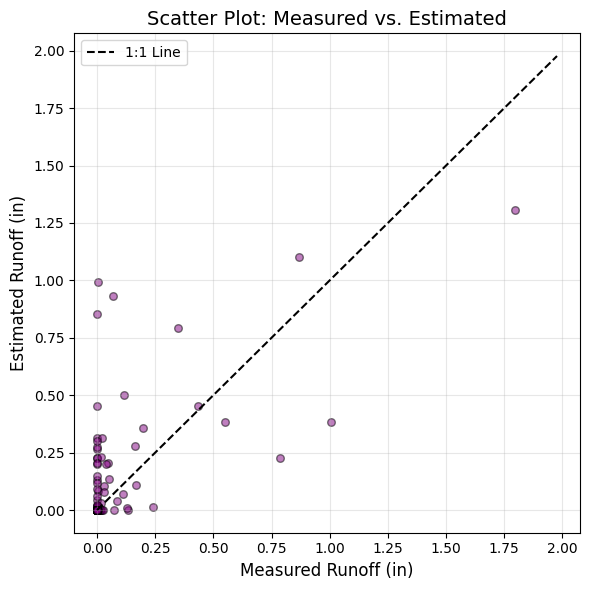

In [29]:
# ---VISUALIZATION  ---
import matplotlib.dates as mdates

# 1. Sort by Date (Crucial for line plots!)
df = df.sort_values("Date")

# 2. Extract aligned variables
obs = df["Measured_Runoff"]
sim = df["Estimated_Runoff"]  # Make sure this column name matches your dataframe
date = df["Date"]

# --- PLOT 1: TIME SERIES ---
plt.figure(figsize=(12, 6))

# Plot the lines
plt.plot(date, obs, label="Measured", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(
    date,
    sim,
    label=f"Estimated (CN={CN_VALUE})",
    color="red",
    linestyle="--",
    alpha=0.8,
    linewidth=1.5,
)

# Formatting
plt.ylabel("Runoff (in)", fontsize=12)
plt.title(f"Runoff Time Series (CN={CN_VALUE})", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# Fix X-Axis Date formatting (Prevents "messy" axis)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(
    mdates.MonthLocator(interval=3)
)  # Show tick every 3 months
plt.gcf().autofmt_xdate()  # Rotate dates slightly

plt.tight_layout()
plt.savefig("runoff_timeseries.png", dpi=300)
print("Saved plot: runoff_timeseries.png")

# --- PLOT 2: SCATTER ---
plt.figure(figsize=(6, 6))
plt.scatter(obs, sim, alpha=0.5, color="purple", edgecolors="k", s=30)

# 1:1 Reference Line
max_val = max(obs.max(), sim.max()) * 1.1
plt.plot([0, max_val], [0, max_val], "k--", lw=1.5, label="1:1 Line")

plt.xlabel("Measured Runoff (in)", fontsize=12)
plt.ylabel("Estimated Runoff (in)", fontsize=12)
plt.title("Scatter Plot: Measured vs. Estimated", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("runoff_scatter.png", dpi=300)
print("Saved plot: runoff_scatter.png")

plt.show()

## Optionnal analysis : Optimization : 

In [31]:
# ---- AUTOMATED PARAMETER OPTIMIZATION ---
def optimize_cn(rainfall, observed_runoff):
    best_cn = 0
    lowest_rmse = float("inf")

    # Test every CN from 70 to 95
    for cn in range(70, 95):
        sim = calculate_scs_runoff(rainfall, cn)
        current_rmse = np.sqrt(mean_squared_error(observed_runoff, sim))

        if current_rmse < lowest_rmse:
            lowest_rmse = current_rmse
            best_cn = cn

    return best_cn, lowest_rmse


# Run the optimization
opt_cn, opt_rmse = optimize_cn(df["Rainfall"], df["Measured_Runoff"])

print("\n--- OPTIMIZATION RESULTS ---")
print(f"The mathematically optimal CN for this dataset is: {opt_cn}")
print(f"This improves RMSE from {rmse:.3f} to {opt_rmse:.3f}")


--- OPTIMIZATION RESULTS ---
The mathematically optimal CN for this dataset is: 77
This improves RMSE from 0.070 to 0.059


## ---  DYNAMIC CN (AMC ADJUSTMENT) ---

In [33]:

# Calculate 5-day rolling rainfall sum
df["AMC_Rain"] = df["Rainfall"].rolling(window=5).sum().shift(1).fillna(0)


# Define Function for Dynamic CN
def get_dynamic_cn(amc_rain, base_cn):
    # Formulas from USDA NEH-4
    cn_I = 4.2 * base_cn / (10 - 0.058 * base_cn)  # Dry Condition
    cn_III = 23 * base_cn / (10 + 0.13 * base_cn)  # Wet Condition

    cn_list = []
    for rain in amc_rain:
        if rain < 1.4:  # Dry (Dormant season limit)
            cn_list.append(cn_I)
        elif rain > 2.1:  # Wet
            cn_list.append(cn_III)
        else:  # Normal
            cn_list.append(base_cn)
    return np.array(cn_list)


# Calculate Dynamic Runoff
dynamic_cn_values = get_dynamic_cn(df["AMC_Rain"], CN_VALUE)
df["Dynamic_Runoff"] = calculate_scs_runoff(df["Rainfall"], dynamic_cn_values)

# Calculate Stats for Dynamic Model
r2_dyn = r2_score(obs, df["Dynamic_Runoff"])
print(f"Dynamic Model R2: {r2_dyn:.3f}")

Dynamic Model R2: 0.491
